In [1]:
import pandas as pd
from datetime import date

In [2]:
def read(name: str):
    return pd.read_csv(f'./данные для исследований/{name}', sep=';').drop(columns=['dataset'])

In [3]:
ort = read('Оборот розничной торговли, Россия — Диаграмма.csv')
ipc = read('Индекс потребительских цен, Россия — Диаграмма.csv')
zp = read('Заработная плата, Россия — Диаграмма.csv')
zn = read('Занятость населения, Россия — Диаграмма.csv')
imp = read('Ежемесячный импорт, млн долларов США, Россия — Диаграмма.csv')
ibk = read('Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия — Диаграмма.csv')
ni = read('Новостной идекс ЦБ, Россия — Диаграмма.csv')

у новостного индекса на начало месяца

In [4]:
ni.head(1)
ni.date = pd.to_datetime(ni.date, format='%d.%m.%Y').dt.date

In [35]:
df = (ort.merge(ipc, on='date')
 .merge(zp, on='date')
 .merge(zn, on='date')
 .merge(imp, on='date')
 .merge(ibk, on='date')
)

df.date = pd.to_datetime(df.date, format='%d.%m.%Y').apply(lambda x: date(year=x.year, month=x.month, day=1))

df = df.merge(ni, on='date')

df = df.rename(columns={
    'Оборот розничной торговли, Россия: ежемесячные данные|в % к соответствующему периоду предыдущего года (в сопоставимых ценах)|Всего': 'Оборот розничной торговли',
    'Индекс потребительских цен, Россия: в % к предыдущему месяцу': 'Индекс потребительских цен',
    'Заработная плата, Россия: ежемесячные данные|Реальная начисленная заработная плата работников организаций|в % к соответствующему периоду предыдущего года': 'Заработная плата',
    'Занятость населения, Россия: ежемесячные данные|Численность официально зарегистрированных безработных в органах службы занятости населения, которые получают пособие по безработице, на конец месяца|тыс. человек': 'Занятость населения',
    'Ежемесячный импорт, млн долларов США, Россия': 'Импорт',
    'Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия': 'Индикатор бизнес климата'
}
)

In [7]:
df.to_csv('./данные для исследований/оборот_розничной_торговли_факторы.csv')

# 1. Визуальный анализ до обработки

In [36]:
import seaborn as sns

<Axes: >

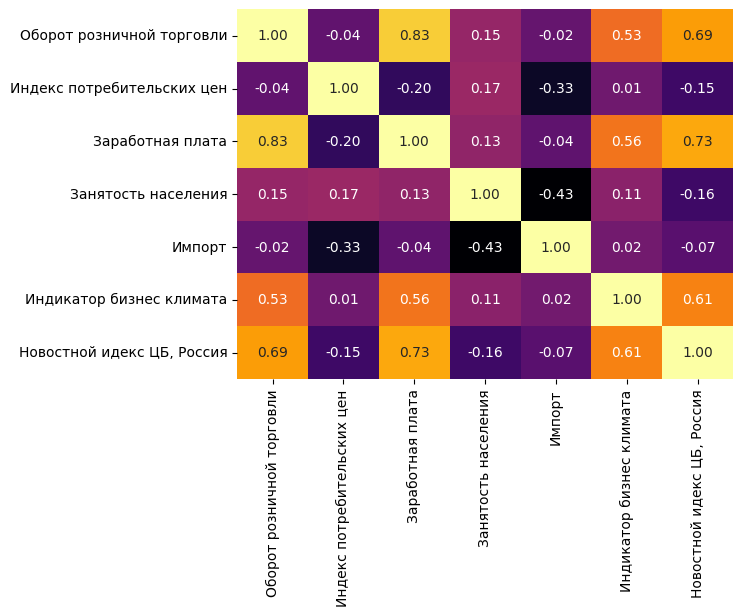

In [37]:
sns.heatmap(
    df.drop(columns=['date']).corr(),
    fmt=".2f",
    # ax=ax,
    annot=True,
    cmap='inferno',
    cbar=False
)

# 2. Предобработка. Добавление факторов с лагом. Приведение к процентам к предыдущему году

In [38]:
def percents_to_last_year(column: str):
    # переводит в проценты к соотвтетствующему периоду предыдущего года
    return [None] * 12 + [(df[column].iloc[i] - df[column].iloc[i - 12]) / df[column].iloc[i - 12] for i in range(12, df.shape[0])]

In [39]:
df['Импорт % к соотв. периоду'] = percents_to_last_year('Импорт')
df['Занятость населения в %'] = percents_to_last_year('Занятость населения')

In [40]:
features = list(df.drop(columns=['date']).columns)

for column in features:
    df[f'{column}_lag_1'] = df[column].shift(1)
    df[f'{column}_lag_2'] = df[column].shift(2)
    df[f'{column}_lag_3'] = df[column].shift(3)

df['Оборот розничной торговли_lag_1'] = df['Оборот розничной торговли_lag_1'] ** 2
df['Оборот розничной торговли_lag_2'] = df['Оборот розничной торговли_lag_2'] ** 2
df['Оборот розничной торговли_lag_3'] = df['Оборот розничной торговли_lag_3'] ** 2

In [41]:
df

,date,Оборот розничной торговли,Индекс потребительских цен,Заработная плата,Занятость населения,Импорт,Индикатор бизнес климата,"Новостной идекс ЦБ, Россия",Импорт % к соотв. периоду,Занятость населения в %,...,Индикатор бизнес климата_lag_3,"Новостной идекс ЦБ, Россия_lag_1","Новостной идекс ЦБ, Россия_lag_2","Новостной идекс ЦБ, Россия_lag_3",Импорт % к соотв. периоду_lag_1,Импорт % к соотв. периоду_lag_2,Импорт % к соотв. периоду_lag_3,Занятость населения в %_lag_1,Занятость населения в %_lag_2,Занятость населения в %_lag_3
0,2004-02-01,112.1,110.6,116.7,1316,6334,13.235736,1.283101,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004-03-01,112.2,110.3,115.7,1310,7506,18.900237,1.316614,NaN,NaN,...,NaN,1.283101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-04-01,112.8,110.2,113.9,1299,7473,11.519830,1.544784,NaN,NaN,...,NaN,1.316614,1.283101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-05-01,113.0,110.2,112.8,1246,7122,12.304775,1.278623,NaN,NaN,...,13.235736,1.544784,1.316614,1.283101,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-06-01,112.7,110.1,113.8,1225,7638,18.459249,1.160094,NaN,NaN,...,18.900237,1.278623,1.544784,1.316614,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2023-12-01,110.7,107.4,108.5,320,27795,3.004770,0.460260,-0.065212,-0.225182,...,8.085759,0.848450,0.425872,0.243075,-0.076051,-0.070734,0.048984,-0.215539,-0.260341,-0.259091
239,2024-01-01,108.5,107.4,108.5,306,21370,1.989294,0.906251,-0.112873,-0.238806,...,5.788698,0.460260,0.848450,0.425872,-0.065212,-0.076051,-0.070734,-0.225182,-0.215539,-0.260341
240,2024-02-01,111.7,107.7,110.8,310,23050,14.562286,0.862086,0.023535,-0.230769,...,0.775448,0.906251,0.460260,0.848450,-0.112873,-0.065212,-0.076051,-0.238806,-0.225182,-0.215539
241,2024-03-01,111.1,107.7,112.9,309,22719,16.508354,0.943880,-0.187650,-0.231343,...,3.004770,0.862086,0.906251,0.460260,0.023535,-0.112873,-0.065212,-0.230769,-0.238806,-0.225182


In [42]:
(df.drop(columns=['date'])
 .corr()[['Оборот розничной торговли']]
 .sort_values(by='Оборот розничной торговли'))

,Оборот розничной торговли
Занятость населения в %,-0.264033
Занятость населения в %_lag_1,-0.192973
Занятость населения в %_lag_2,-0.144142
Занятость населения в %_lag_3,-0.112038
Индекс потребительских цен_lag_3,-0.094782
Индекс потребительских цен_lag_2,-0.091262
Импорт_lag_3,-0.082234
Индекс потребительских цен_lag_1,-0.081618
Импорт_lag_2,-0.052551
Индекс потребительских цен,-0.036663


In [43]:
features = [
    'Оборот розничной торговли_lag_1',
    'Заработная плата',
    'Новостной идекс ЦБ, Россия_lag_1',
    'Импорт % к соотв. периоду_lag_1',
    'Индикатор бизнес климата_lag_1'
]

goal = ['Оборот розничной торговли']

<Axes: >

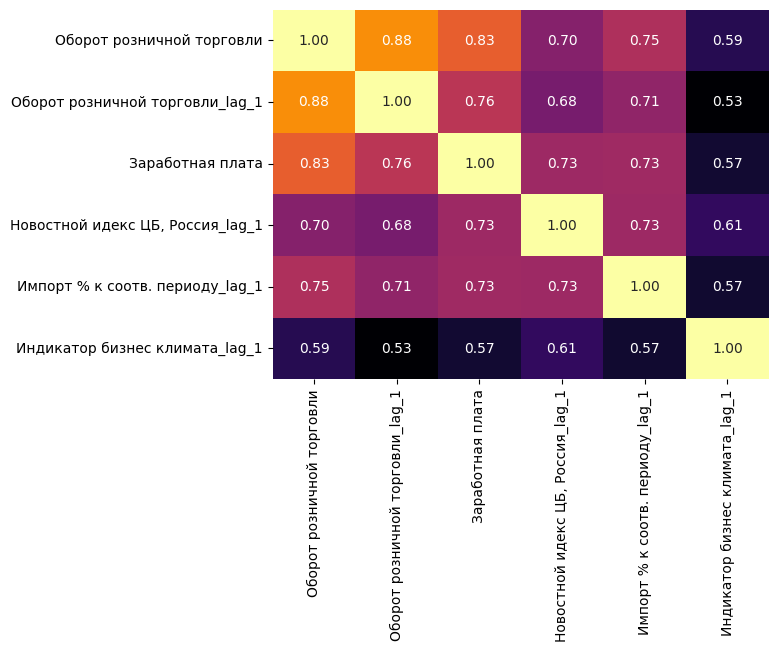

In [44]:
sns.heatmap(
    df[goal + features].corr(),
    fmt=".2f",
    annot=True,
    cmap='inferno',
    cbar=False
)

все между собой коррелирует, надо выделить главную компоненту

# Выделение главной компоненты

In [217]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [223]:
data[features]

,Оборот розничной торговли_lag_1,Заработная плата,"Новостной идекс ЦБ, Россия_lag_1",Импорт % к соотв. периоду_lag_1,Индикатор бизнес климата_lag_1
15,12882.25,107.7,1.098424,0.275391,9.296435
16,13087.36,107.6,1.133131,0.327015,11.795654
17,12904.96,108.3,0.949183,0.295889,14.075873
18,12723.84,110.1,1.010832,0.327309,14.553954
19,12814.24,112.3,0.982892,0.322072,16.097066
...,...,...,...,...,...
238,12232.36,108.5,0.848450,-0.076051,0.775448
239,12254.49,108.5,0.460260,-0.065212,3.004770
240,11772.25,110.8,0.906251,-0.112873,1.989294
241,12476.89,112.9,0.862086,0.023535,14.562286


In [225]:
data = df.dropna()
X, y = data[features], data['Оборот розничной торговли']

# Создаем экземпляр PCA с заданным порогом
pca = PCA(0.95)  # сохраняем 95% доли объясненной дисперсии

# Обучаем PCA на данный X
X_reduced = pca.fit_transform(X)

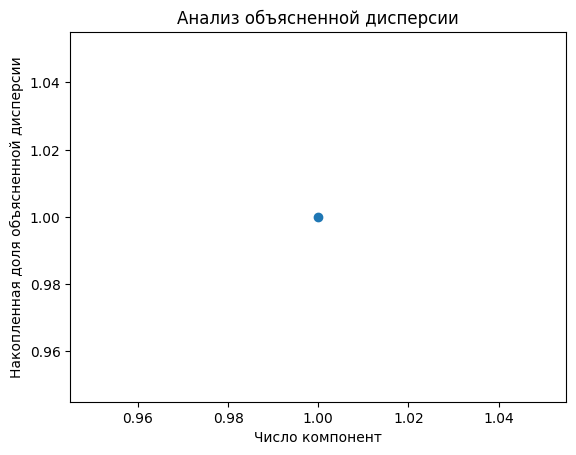

In [226]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Визуализация объясненной дисперсии
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel("Число компонент")
plt.ylabel("Накопленная доля объясненной дисперсии")
plt.title("Анализ объясненной дисперсии")
plt.show()

In [20]:
import matplotlib.pyplot as plt

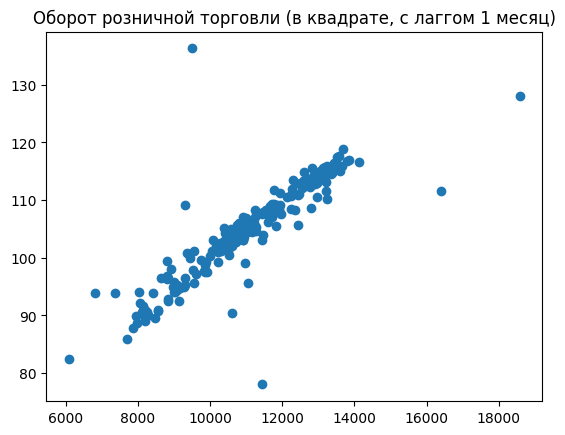

In [47]:
plt.title('Оборот розничной торговли (в квадрате, с лаггом 1 месяц)')
plt.scatter(df['Оборот розничной торговли_lag_1'], df['Оборот розничной торговли'])

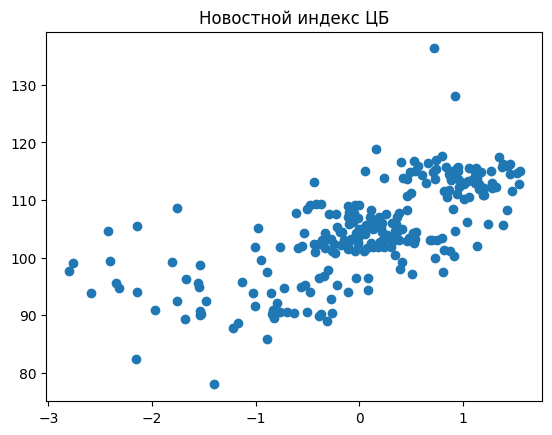

In [23]:
plt.title('Новостной индекс ЦБ')
plt.scatter(df['Новостной идекс ЦБ, Россия'], df['Оборот розничной торговли'])

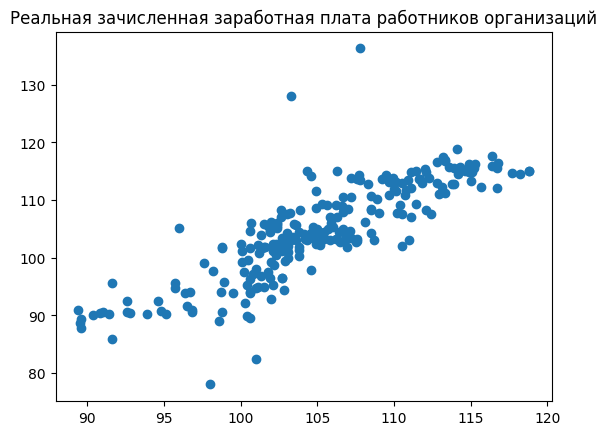

In [27]:
plt.title('Реальная зачисленная заработная плата работников организаций')
plt.scatter(df['Заработная плата'], df['Оборот розничной торговли'])

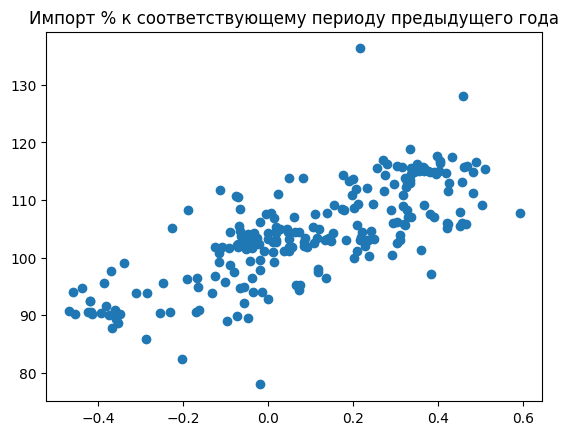

In [26]:
plt.title('Импорт % к соответствующему периоду предыдущего года')
plt.scatter(df['Импорт % к соотв. периоду_lag_1'], df['Оборот розничной торговли'])

# Модель на основе реальной зарплаты в % и предыдущего значения

In [29]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

In [207]:
exog_var = [
    'Оборот розничной торговли_lag_2',
    'Новостной идекс ЦБ, Россия_lag_1',
    'Заработная плата_lag_1',
    'Индикатор бизнес климата_lag_1'
]

X_train, X_test, y_train, y_test = train_test_split(df[exog_var], df[goal], test_size = 0.15, random_state = 42,shuffle=False)

In [208]:
model_1 = CatBoostRegressor(verbose=False, loss_function='RMSE')

grid = {
    'iterations':    [6, 8, 16, 32], 
    'depth':         [3, 6, 8, 10],
    'l2_leaf_reg':   [0.005, 0.01,  0.1,  0.5, 1],
    'learning_rate': [0.001, 0.01, 0.1, 0.5, 1]
}


res = model_1.grid_search(
    grid, X_train, y_train,
    calc_cv_statistics=True,
    search_by_train_test_split=True,
    refit=True, verbose=0
)


bestTest = 104.9556173
bestIteration = 5


bestTest = 99.42570545
bestIteration = 5


bestTest = 56.28496213
bestIteration = 5


bestTest = 6.079276028
bestIteration = 5


bestTest = 5.805605761
bestIteration = 0


bestTest = 104.9557409
bestIteration = 5


bestTest = 99.4268952
bestIteration = 5


bestTest = 56.29301597
bestIteration = 5


bestTest = 6.073880754
bestIteration = 5


bestTest = 5.801538365
bestIteration = 0


bestTest = 104.9579065
bestIteration = 5


bestTest = 99.44773329
bestIteration = 5


bestTest = 56.43419615
bestIteration = 5


bestTest = 6.034125305
bestIteration = 5


bestTest = 5.812654042
bestIteration = 0


bestTest = 104.9665359
bestIteration = 5


bestTest = 99.5307347
bestIteration = 5


bestTest = 56.99670328
bestIteration = 5


bestTest = 6.826983649
bestIteration = 5


bestTest = 6.340695119
bestIteration = 3


bestTest = 104.9759457
bestIteration = 5


bestTest = 99.62119616
bestIteration = 5


bestTest = 57.60719173
bestIteration = 5


bestTest = 8

In [209]:
res['params']

{'depth': 3, 'learning_rate': 0.5, 'l2_leaf_reg': 0.1, 'iterations': 16}

In [210]:
model = CatBoostRegressor(**res['params'], verbose = False)
model.fit(X_train, y_train)

# Качество модели

In [82]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import numpy as np

In [211]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print(f'r2_score: {np.round(r2_score(y_train, train_predict), 4)}')
print(f'mape train: {np.round(mean_absolute_percentage_error(y_train, train_predict), 4) * 100:0.2f}%')
print(f'mape test: {np.round(mean_absolute_percentage_error(y_test, test_predict), 4) * 100:0.2f}%')


r2_score: 0.9564
mape train: 1.19%
mape test: 4.58%


- r2_score: 0.9785
- mape train: 0.86%
- mape test: 4.66%

Корреляция тестовой выборки и прогноза

In [212]:
train_df = pd.DataFrame({'y_train': y_train['Оборот розничной торговли'], 'train_predict': train_predict})
test_df = pd.DataFrame({'y_test': y_test['Оборот розничной торговли'], 'test_predict': test_predict})

test_df.corr()

,y_test,test_predict
y_test,1.000000,0.626097
test_predict,0.626097,1.000000


In [195]:
train_df.shape

(206, 2)

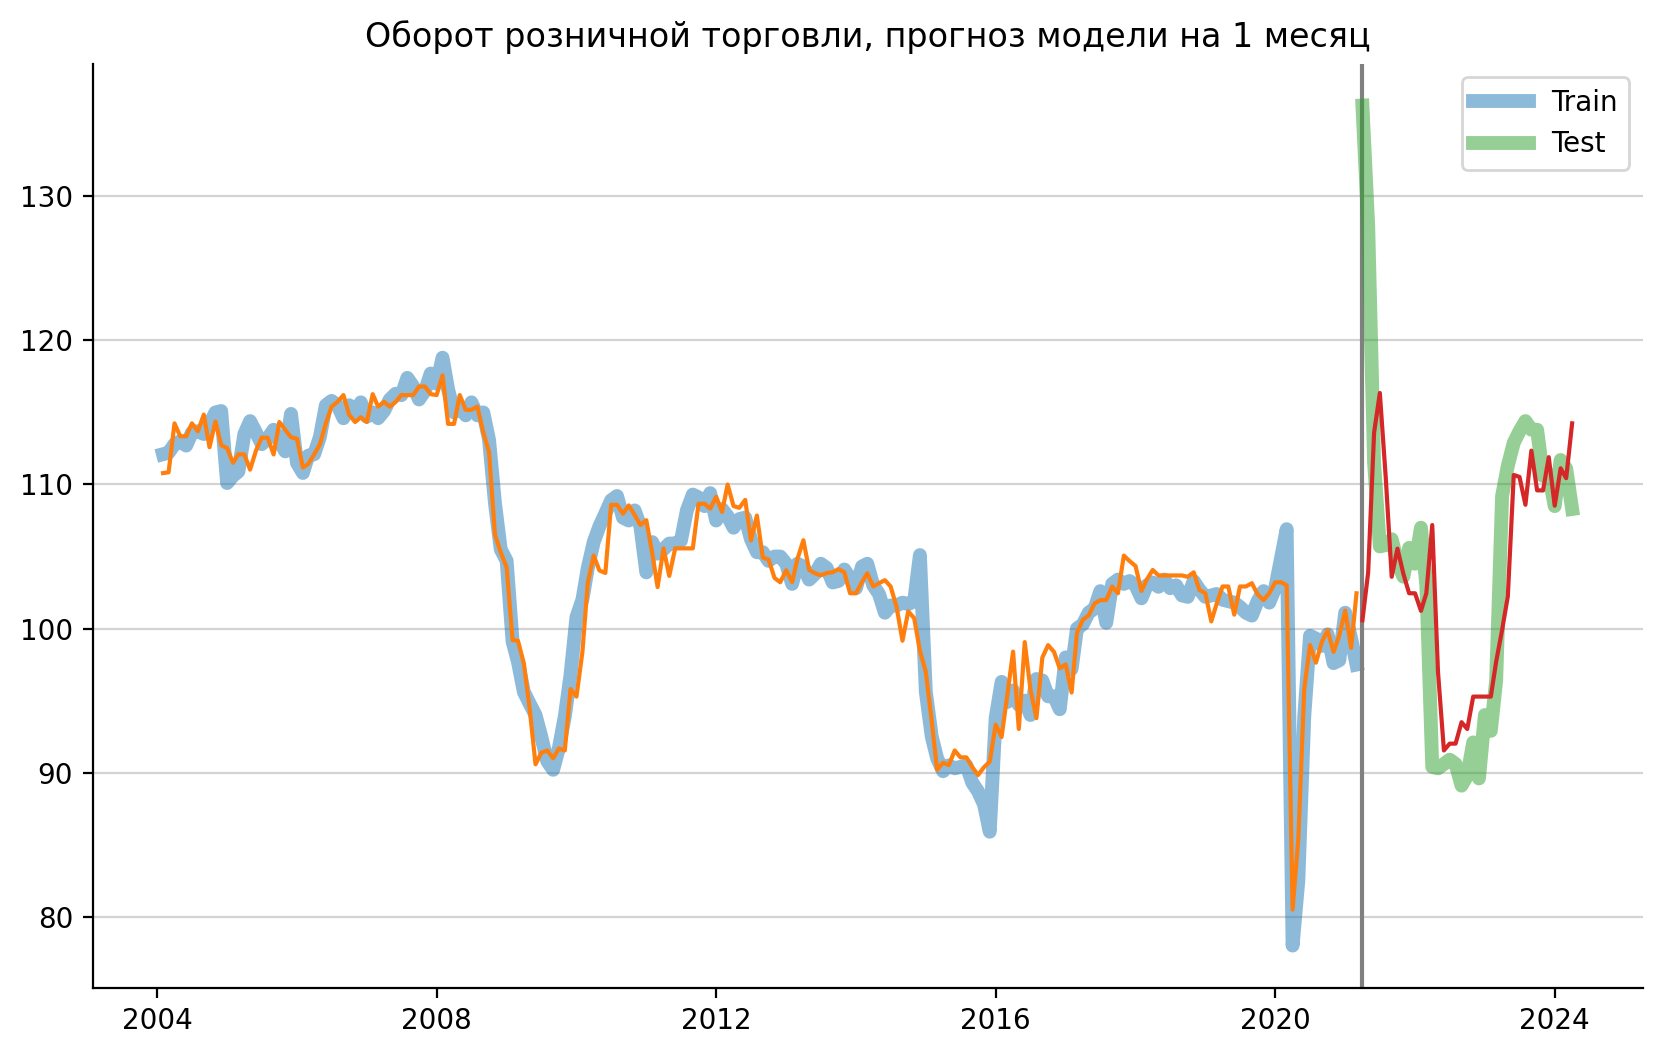

In [213]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

plt.title("Оборот розничной торговли, прогноз модели на 1 месяц",fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(axis='y', color='lightgrey')

plt.plot(df.date[:206], df['Оборот розничной торговли'][:206], label='Train', linewidth=5, alpha=0.5)
plt.plot(df.date[:206], train_df.train_predict)

plt.axvline(df.date[206], color='grey')
plt.plot(df.date[206:], df['Оборот розничной торговли'][206:], label='Test', linewidth=5, alpha=0.5)
plt.plot(df.date[206:], test_df.test_predict)

ax.legend()